In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline

from matplotlib.pylab import rcParams

import warnings
warnings.filterwarnings('ignore')

###### Import the data

In [2]:
data = pd.read_csv('Base.csv',encoding = "utf-8", delimiter=';', decimal=",")
data.head(5)

,Ano,Mes,Filial,Venda
0,2016,1,802.003,"496.641,22"
1,2017,1,802.003,"703.108,97"
2,2016,2,802.003,"730.361,71"
3,2017,2,802.003,"644.698,86"
4,2016,3,802.003,"696.540,02"


In [3]:
data['Filial'] = data['Filial'].astype(str)
data['Venda'] = data['Venda'].astype(str)

data['Venda'] = [x.replace('.', '') for x in data['Venda']]
data['Venda'] = [x.replace(',', '.') for x in data['Venda']]

data['Venda'] = data['Venda'].astype(float)


periods = []
for index,el in enumerate(data.values):
   periods.append((str(el[0]) + '-' + str(el[1])))

clean_data = data[['Venda', 'Filial']]

periods = pd.DatetimeIndex(periods)
clean_data = clean_data.set_index(periods)
clean_data.index.name = 'Date'

In [4]:
data = clean_data.sort_index()
data.sample(5)

,Venda,Filial
Date,,
2016-02-01,381961.56,802.054
2016-02-01,838017.19,802.014
2016-11-01,459867.17,802.046
2017-04-01,145757.19,802.025
2017-02-01,644698.86,802.003


Unlike numeric indexing, the end index is included here. For instance, if we index a list as a[:5] then it would return the values at indices – [0,1,2,3,4]. But here the end index is include in the output.

In [5]:
Filiais = []
for i in data['Filial'].values:
    if(i not in Filiais):
        Filiais.append(i)
print('Número de Filiais: {}'.format(len(Filiais)))

Número de Filiais: 14


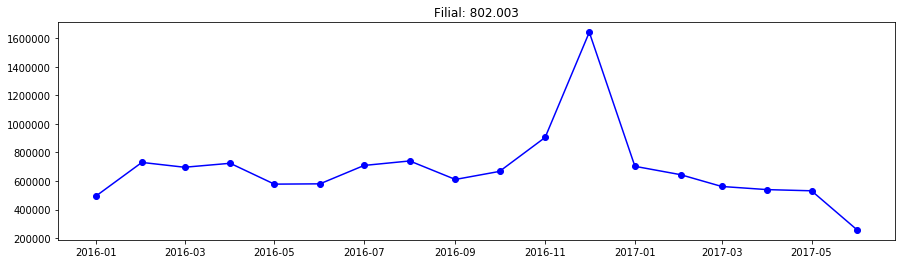

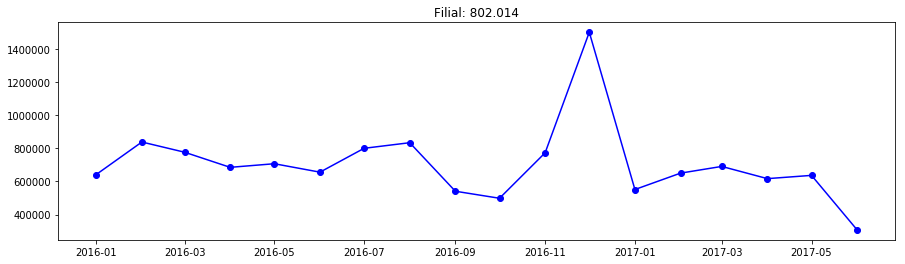

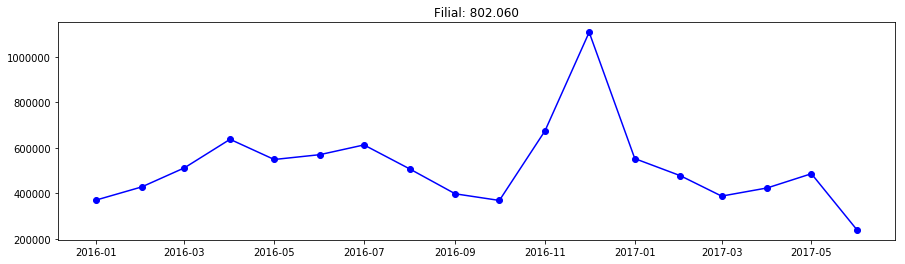

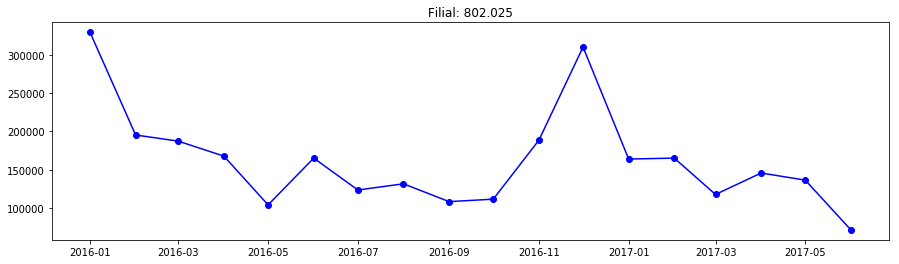

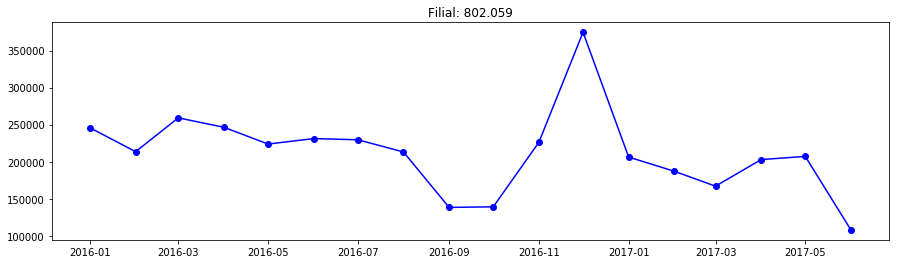

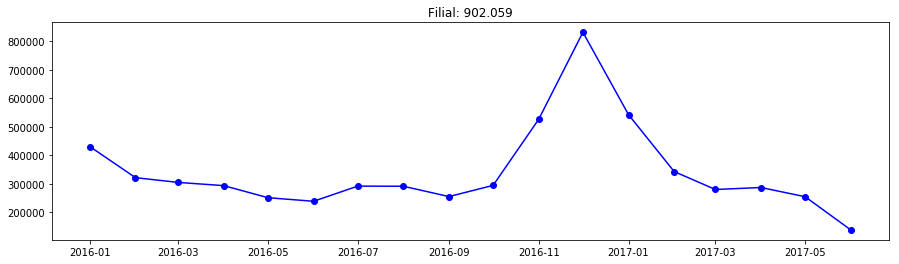

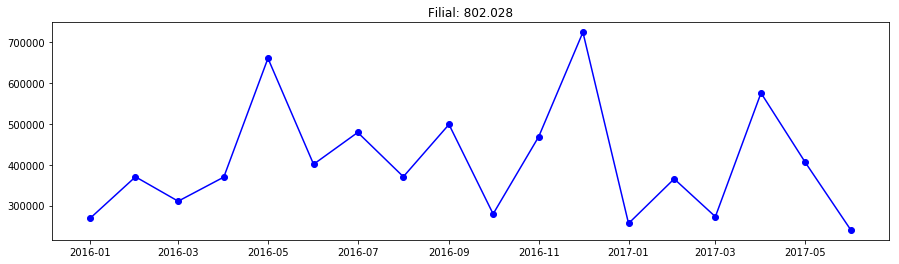

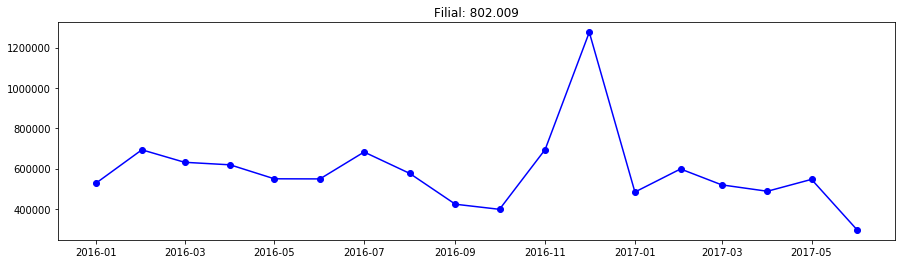

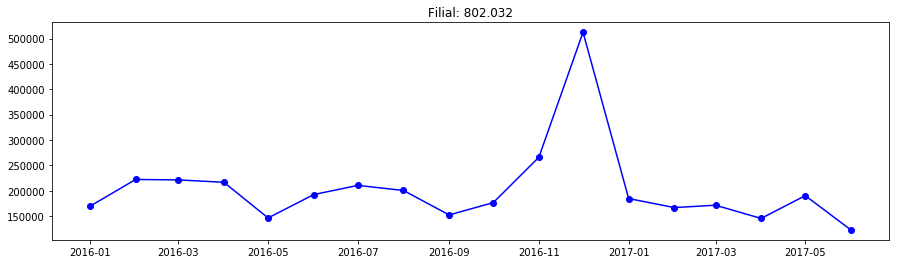

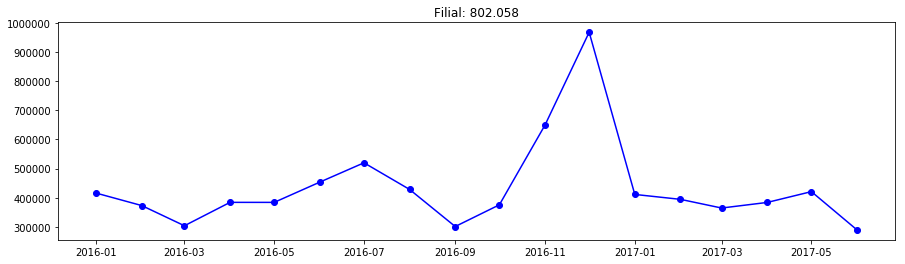

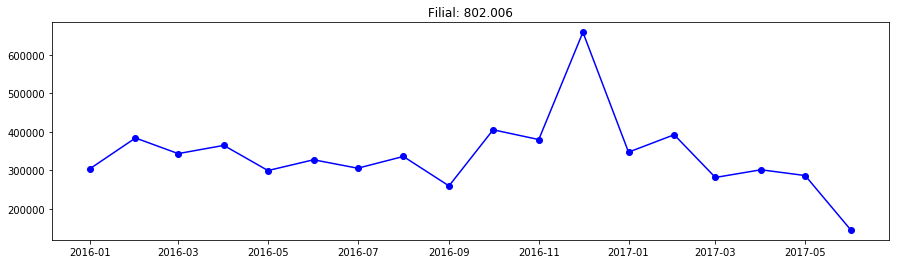

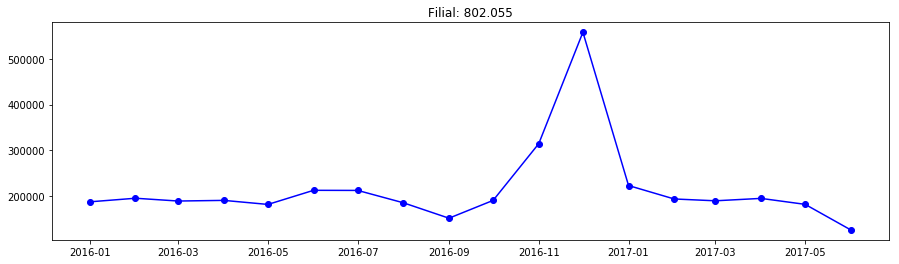

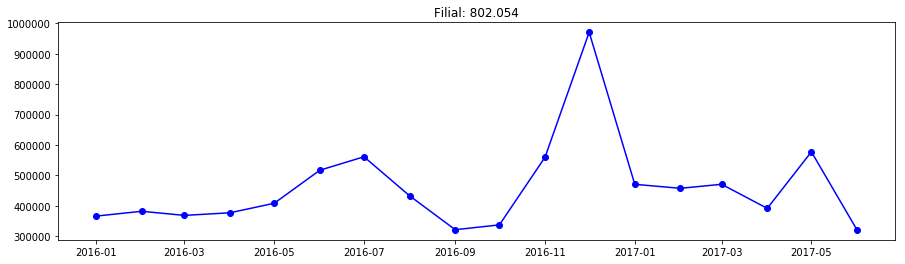

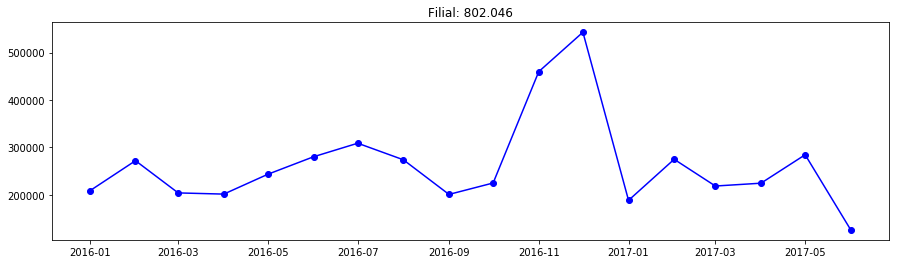

In [6]:
rcParams['figure.figsize'] = 15,4

for filial in Filiais:
    plt.title('Filial: ' + filial)
    plt.plot(data[data['Filial']==filial]['Venda'], 'b-o')
    plt.figure()

##### Try to predict in a macro view

In [7]:
data_macro = data['Venda'].groupby('Date').sum()

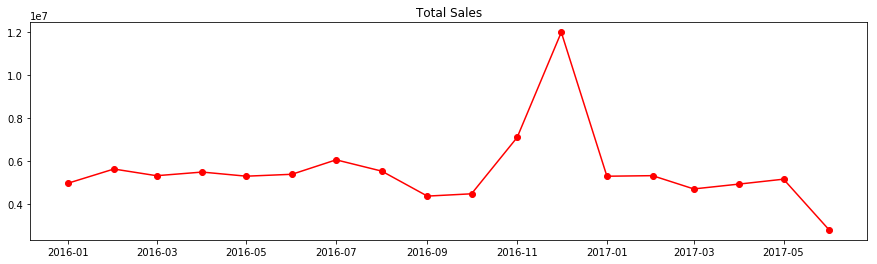

In [8]:
plt.title('Total Sales')
plt.plot(data_macro, 'r-o')

<strong>Probably the sales of the last month isn't complete. This month will be excluded</strong>

In [9]:
del_data = data['2017-05']
data = data[:'2017-05']
data_macro = data_macro[:'2017-05'] 

In [10]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 5, title = '', show_std = True):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=window)
    if(show_std):
        rolstd = pd.rolling_std(timeseries, window=window)
    
    rolewma = pd.ewma(timeseries, halflife=window)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    if(show_std):
        std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    mean2 = plt.plot(rolewma, color='green', label = 'Rolling EWMA')

    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation to: {}'.format(title))
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

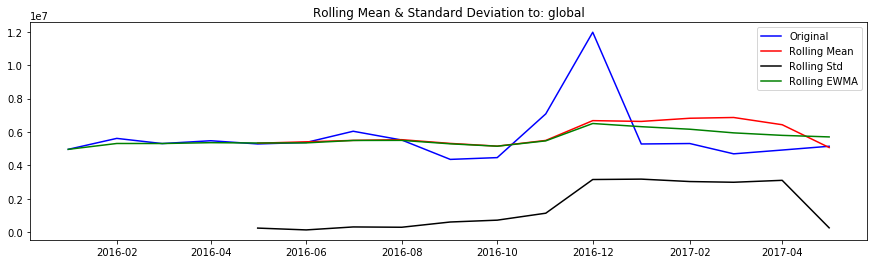

Results of Dickey-Fuller Test:
Test Statistic                 0.000000
p-value                        0.958532
#Lags Used                     7.000000
Number of Observations Used    9.000000
Critical Value (1%)           -4.473135
Critical Value (5%)           -3.289881
Critical Value (10%)          -2.772382
dtype: float64


In [11]:
test_stationarity(data_macro, window=5, title= 'global')

In [12]:
#_ = [test_stationarity(data[data['Filial']==filial]['Venda'], window=5, title= filial) for filial in Filiais]

<strong>Why do I care about ‘stationarity’ of a time series?</strong> <br><hr>
Until unless your time series is stationary, you cannot build a time series model. In cases where the stationary criterion are violated, the first requisite becomes to stationarize the time series and then try stochastic models to predict this time series. There are multiple ways of bringing this stationarity. Some of them are Detrending, Differencing etc. https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/

Lets understand what is making a TS non-stationary. There are 2 major reasons behind non-stationaruty of a TS:
1. Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
2. Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

##### Differencing

One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity

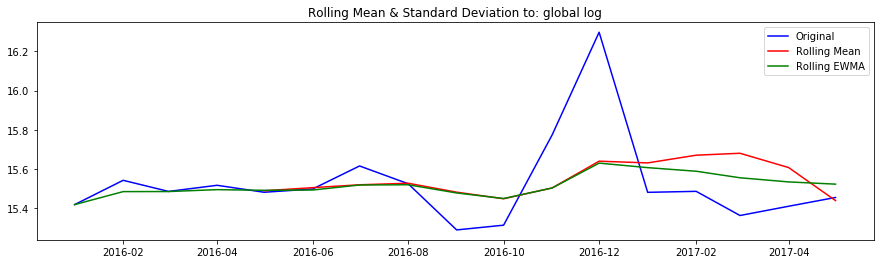

Results of Dickey-Fuller Test:
Test Statistic                -0.000000
p-value                        0.958532
#Lags Used                     8.000000
Number of Observations Used    8.000000
Critical Value (1%)           -4.665186
Critical Value (5%)           -3.367187
Critical Value (10%)          -2.802961
dtype: float64


In [13]:
#First Try to use Log to penalize higher values more then smaller values
data_macro_log = np.log(data_macro)
test_stationarity(data_macro_log, window=5, title= 'global log', show_std = False)

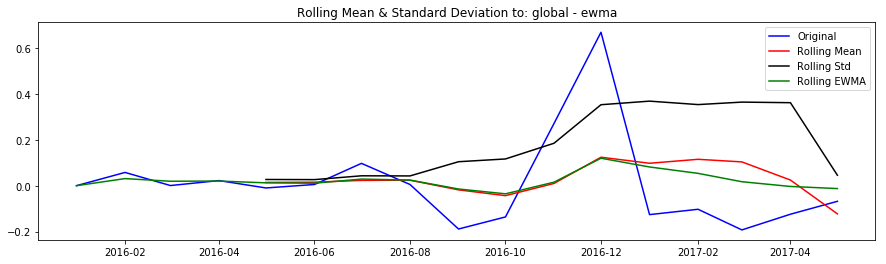

Results of Dickey-Fuller Test:
Test Statistic                -0.000000
p-value                        0.958532
#Lags Used                     7.000000
Number of Observations Used    9.000000
Critical Value (1%)           -4.473135
Critical Value (5%)           -3.289881
Critical Value (10%)          -2.772382
dtype: float64


In [14]:
expwighted_avg = pd.ewma(data_macro_log, halflife=5)
test_stationarity(data_macro_log-expwighted_avg, window=5, title= 'global - ewma', show_std = True)

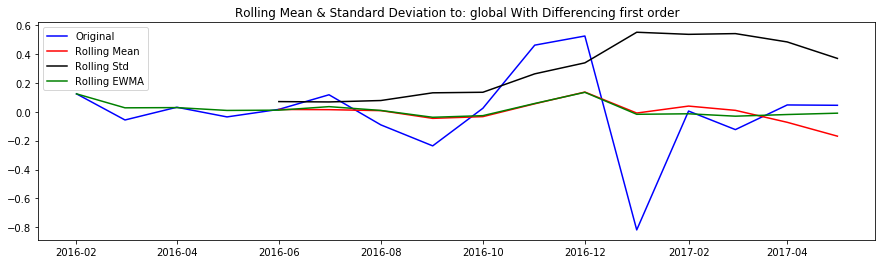

Results of Dickey-Fuller Test:
Test Statistic                 -2.092681
p-value                         0.247468
#Lags Used                      5.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64


In [15]:
data_macro_log_diff = data_macro_log - data_macro_log.shift()
data_macro_log_diff.dropna(inplace=True)
test_stationarity(data_macro_log_diff, window=5, title= 'global With Differencing first order', show_std = True)

##### Decomposing
In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned.

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_macro_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

if(trend.isnull().values.any() or seasonal.isnull().values.any() or residual.isnull().values.any()):
    print('Null values: Trend or seasonal or residual')
else:
    plt.subplot(411)
    plt.plot(data_macro_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')


Null values: Trend or seasonal or residual
